# Fully Convolutional Networks for Change Detection

*(Adapted version to PRISMA datasets)*

Example code for training the network presented in the paper:

```
Daudt, R.C., Le Saux, B. and Boulch, A., 2018, October. Fully convolutional siamese networks for change detection. In 2018 25th IEEE International Conference on Image Processing (ICIP) (pp. 4063-4067). IEEE.
```

Code uses the OSCD dataset:

```
Daudt, R.C., Le Saux, B., Boulch, A. and Gousseau, Y., 2018, July. Urban change detection for multispectral earth observation using convolutional neural networks. In IGARSS 2018-2018 IEEE International Geoscience and Remote Sensing Symposium (pp. 2115-2118). IEEE.
```


FresUNet architecture from paper:

```
Daudt, R.C., Le Saux, B., Boulch, A. and Gousseau, Y., 2019. Multitask learning for large-scale semantic change detection. Computer Vision and Image Understanding, 187, p.102783.
```

Please consider all relevant papers if you use this code.

In [1]:
# Rodrigo Daudt
# rcdaudt.github.io
# rodrigo.daudt@onera.fr

In [2]:
!git clone https://github.com/fserva2/fully_convolutional_change_detection # FS

Cloning into 'fully_convolutional_change_detection'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), done.


In [3]:
import sys # FS
sys.path.insert(0,'/content/fully_convolutional_change_detection')

In [4]:
# Imports

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as tr

# Models
from unet import Unet
from siamunet_conc import SiamUnet_conc # not used in the current project
from siamunet_diff import SiamUnet_diff # not used in the current project
from fresunet import FresUNet # not used in the current project

# Other
import os
import numpy as np
import random
from skimage import io
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
from IPython import display
import time
from itertools import chain
import time
import warnings
from pprint import pprint



print('IMPORTS OK')


IMPORTS OK


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# Some output files will be saved in your drive storage

In [7]:
!ls drive/MyDrive/PRISMA

'PRISMA - Images.zip'  'PRISMA - Test Labels.zip'  'PRISMA - Train Labels.zip'


In [8]:
"""
!unzip "drive/MyDrive/OSCD/Onera Satellite Change Detection dataset - Images.zip"
!unzip "drive/MyDrive/OSCD/Onera Satellite Change Detection dataset - Test Labels.zip"
!unzip "drive/MyDrive/OSCD/Onera Satellite Change Detection dataset - Train Labels.zip"
"""

'\n!unzip "drive/MyDrive/OSCD/Onera Satellite Change Detection dataset - Images.zip"\n!unzip "drive/MyDrive/OSCD/Onera Satellite Change Detection dataset - Test Labels.zip"\n!unzip "drive/MyDrive/OSCD/Onera Satellite Change Detection dataset - Train Labels.zip"\n'

In [9]:

!unzip "drive/MyDrive/PRISMA/PRISMA - Images.zip"
!unzip "drive/MyDrive/PRISMA/PRISMA - Test Labels.zip"
!unzip "drive/MyDrive/PRISMA/PRISMA - Train Labels.zip"


Archive:  drive/MyDrive/PRISMA/PRISMA - Images.zip
   creating: PRISMA - Images/
  inflating: __MACOSX/._PRISMA - Images  
  inflating: PRISMA - Images/.DS_Store  
  inflating: __MACOSX/PRISMA - Images/._.DS_Store  
  inflating: PRISMA - Images/all.txt  
  inflating: __MACOSX/PRISMA - Images/._all.txt  
   creating: PRISMA - Images/Aus_fire_01/
   creating: PRISMA - Images/Aus_mine/
   creating: PRISMA - Images/Be_01/
  inflating: __MACOSX/PRISMA - Images/._Be_01  
   creating: PRISMA - Images/Clark_reef/
   creating: PRISMA - Images/Greece/
  inflating: __MACOSX/PRISMA - Images/._Greece  
   creating: PRISMA - Images/Ind_urb_riv/
  inflating: __MACOSX/PRISMA - Images/._Ind_urb_riv  
   creating: PRISMA - Images/Indo_01/
   creating: PRISMA - Images/LA/
  inflating: __MACOSX/PRISMA - Images/._LA  
   creating: PRISMA - Images/Lagos_Nig/
  inflating: __MACOSX/PRISMA - Images/._Lagos_Nig  
   creating: PRISMA - Images/Lake_Frome/
   creating: PRISMA - Images/London/
  inflating: __MACOSX

In [10]:
#!ls "Onera Satellite Change Detection dataset - Images"
# Merge individual folders into one single folder used for input
!ls
!mkdir PRISMA
!cp -rf PRISMA*/* PRISMA
!ls PRISMA

 drive				       'PRISMA - Images'	 sample_data
 fully_convolutional_change_detection  'PRISMA - Test Labels'
 __MACOSX			       'PRISMA - Train Labels'
all.txt      Clark_reef   LA	      NY	  Shanghai
Aus_fire_01  Greece	  Lagos_Nig   Po_01	  test.txt
Aus_mine     Indo_01	  Lake_Frome  README.txt  train.txt
Be_01	     Ind_urb_riv  London      Rome_01


In [11]:
# Global Variables' Definitions

PATH_TO_DATASET = './PRISMA/' 
IS_PROTOTYPE = False

FP_MODIFIER = 1 # Tuning parameter, use 1 if unsure

BATCH_SIZE = 11 #32
PATCH_SIDE = 96 #96
N_EPOCHS = 20 #73


#230-7|170-5|120-3|80-2
MAX_BAND_DATASET=80 # It depends on the dataset.
PICK_EVERY_X_BAND=2
MAX_BAND_SUBSET=int(round(MAX_BAND_DATASET/PICK_EVERY_X_BAND,0))

NORMALISE_IMGS = True

TRAIN_STRIDE = int(PATCH_SIDE/2) - 1

LOAD_TRAINED = False

DATA_AUG = True

NWORKERS = 2 # FS, required to run on colab
PATH_OUTPUTS = 'drive/MyDrive/PRISMA_outputs/'
print('DEFINITIONS OK')

DEFINITIONS OK


In [12]:

def append_new_line(file_name, text_to_append):
    """Append given text as a new line at the end of file"""
    # Open the file in append & read mode ('a+')
    with open(file_name, "a+") as file_object:
        # Move read cursor to the start of file.
        file_object.seek(0)
        # If file is not empty then append '\n'
        data = file_object.read()
        if len(data) > 0:
            file_object.write("\n")
        # Append text at the end of file
        file_object.write(text_to_append)

file_name=PATH_OUTPUTS+'Report_exec.txt'
#time = time.time()
line=str(BATCH_SIZE)+' '+str(PATCH_SIDE)+' '+str(N_EPOCHS)+' '+str(MAX_BAND_DATASET)+' '+str(PICK_EVERY_X_BAND)+' '+str(MAX_BAND_SUBSET)
append_new_line(file_name, line)

In [13]:
## UNCHANGED FROM ORIGINAL VERSION
def adjust_shape(I, s):
    """Adjust shape of grayscale image I to s."""
    
    # crop if necesary
    I = I[:s[0],:s[1]]
    si = I.shape
    
    # pad if necessary 
    p0 = max(0,s[0] - si[0])
    p1 = max(0,s[1] - si[1])
    
    return np.pad(I,((0,p0),(0,p1)),'edge')

def reshape_for_torch(I):
    """Transpose image for PyTorch coordinates."""
#     out = np.swapaxes(I,1,2)
#     out = np.swapaxes(out,0,1)
#     out = out[np.newaxis,:]
    out = I.transpose((2, 0, 1))
    return torch.from_numpy(out)

## EDITED FUNCS TO READ DATA FROM PRISMA ################################

def create_subset_vector(max_band=MAX_BAND_DATASET,pick=PICK_EVERY_X_BAND):
    b=[]
    a=np.arange(MAX_BAND_DATASET)
    for idx,bands in enumerate(a):
            if idx%PICK_EVERY_X_BAND==0:
                c=1
            else:
                c=0
            b.append(c)
        #print(idx,b,idx%2)
    b=np.array(b)
    return b

def read_prisma(path,subset):
    """Read cropped PRISMA image."""
    im_name = os.listdir(path)[0] #[:-7]
    I = np.load(path + im_name)
    I=I[:,:,:MAX_BAND_DATASET]
    I=I[:,:,np.nonzero(subset)[0]] # subset the bands in the reading
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_prisma_trio(path):
    """Read cropped PRISMA image pair and change map."""
#     read images
    subset_vector=create_subset_vector()
    I1 = read_prisma(path + '/imgs_1/',subset_vector)
    I2 = read_prisma(path + '/imgs_2/',subset_vector)  
    cm = io.imread(path + '/cm/cm.png', as_gray=True) != 0
    
    return I1, I2, cm
################################

## UNCHANGED FROM ORIGINAL VERSION

class RandomFlip(object):
    """Flip randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        if random.random() > 0.5:
            I1 =  I1.numpy()[:,:,::-1].copy()
            I1 = torch.from_numpy(I1)
            I2 =  I2.numpy()[:,:,::-1].copy()
            I2 = torch.from_numpy(I2)
            label =  label.numpy()[:,::-1].copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}
################################################################

## EDITED VERSION OF CD-DATASET Class definition

class ChangeDetectionDataset(Dataset):
    """Change Detection dataset class, used for both training and test data."""

    def __init__(self, path, train = True, patch_side = 512, stride = None, use_all_bands = True, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        # basics
        self.transform = transform
        self.path = path
        self.patch_side = patch_side
        if not stride:
            self.stride = 1
        else:
            self.stride = stride
        
        if train:
            fname = 'train.txt'
        else:
            fname = 'test.txt'
        
#         print(path + fname)
        self.names = read_csv(path + fname).columns
        self.n_imgs = self.names.shape[0]
        
        n_pix = 0
        true_pix = 0
        
        
        # load images
        self.imgs_1 = {}
        self.imgs_2 = {}
        self.change_maps = {}
        self.n_patches_per_image = {}
        self.n_patches = 0
        self.patch_coords = []
        for im_name in tqdm(self.names):
            # load and store each image
            I1, I2, cm = read_prisma_trio(self.path + im_name)
            self.imgs_1[im_name] = reshape_for_torch(I1)
            self.imgs_2[im_name] = reshape_for_torch(I2)

            ########################### CHECKING IF IT WORKS #######################################
            #self.imgs_1[im_name] = I1
            #self.imgs_2[im_name] = I2

            #(IT DIDN´T WORK)
            ##################################################################

            self.change_maps[im_name] = cm
            
            s = cm.shape
            n_pix += np.prod(s)
            true_pix += cm.sum()
            
            # calculate the number of patches
            s = self.imgs_1[im_name].shape
            n1 = ceil((s[1] - self.patch_side + 1) / self.stride)
            n2 = ceil((s[2] - self.patch_side + 1) / self.stride)
            n_patches_i = n1 * n2
            self.n_patches_per_image[im_name] = n_patches_i
            self.n_patches += n_patches_i
            
            # generate path coordinates
            for i in range(n1):
                for j in range(n2):
                    # coordinates in (x1, x2, y1, y2)
                    current_patch_coords = (im_name, 
                                    [self.stride*i, self.stride*i + self.patch_side, self.stride*j, self.stride*j + self.patch_side],
                                    [self.stride*(i + 1), self.stride*(j + 1)])
                    self.patch_coords.append(current_patch_coords)
                    
        self.weights = [ FP_MODIFIER * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix]
       
        

    def get_img(self, im_name):
        return self.imgs_1[im_name], self.imgs_2[im_name], self.change_maps[im_name]

    def __len__(self):
        return self.n_patches

    def __getitem__(self, idx):
        current_patch_coords = self.patch_coords[idx]
        im_name = current_patch_coords[0]
        limits = current_patch_coords[1]
        centre = current_patch_coords[2]
        
        I1 = self.imgs_1[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        I2 = self.imgs_2[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        
        label = self.change_maps[im_name][limits[0]:limits[1], limits[2]:limits[3]]
        label = torch.from_numpy(1*np.array(label)).float()
        
        sample = {'I1': I1, 'I2': I2, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample
###############################################################################################

## UNCHANGED FROM ORIGINAL VERSION

class RandomRot(object):
    """Rotate randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        n = random.randint(0, 3)
        if n:
            I1 =  sample['I1'].numpy()
            I1 = np.rot90(I1, n, axes=(1, 2)).copy()
            I1 = torch.from_numpy(I1)
            I2 =  sample['I2'].numpy()
            I2 = np.rot90(I2, n, axes=(1, 2)).copy()
            I2 = torch.from_numpy(I2)
            label =  sample['label'].numpy()
            label = np.rot90(label, n, axes=(0, 1)).copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}
################################################################

print('UTILS OK')

UTILS OK


In [14]:
# Dataset

if DATA_AUG:
    data_transform = tr.Compose([RandomFlip(), RandomRot()])
else:
    data_transform = None
        

train_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = True, stride = TRAIN_STRIDE, transform=data_transform)
weights = torch.FloatTensor(train_dataset.weights).cuda()
print(weights)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NWORKERS)

test_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = False, stride = TRAIN_STRIDE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NWORKERS)


print('DATASETS OK')

100%|██████████| 11/11 [00:53<00:00,  4.83s/it]


tensor([0.2000, 1.8000], device='cuda:0')


100%|██████████| 4/4 [00:19<00:00,  4.78s/it]

DATASETS OK


In [15]:
 print(weights)

tensor([0.2000, 1.8000], device='cuda:0')


In [16]:
net, net_name = Unet(2*13, 2), 'FC-EF'
#     net, net_name = SiamUnet_conc(13, 2), 'FC-Siam-conc'
#     net, net_name = SiamUnet_diff(13, 2), 'FC-Siam-diff'
#     net, net_name = FresUNet(2*MAX_BAND_SUBSET, 2), 'FresUNet'

net.cuda()

criterion = nn.NLLLoss(weight=weights) # to be used with logsoftmax output

print('NETWORK OK')

NETWORK OK


In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(net))

Number of trainable parameters: 1109794


In [18]:
# net.load_state_dict(torch.load('net-best_epoch-1_fm-0.7394933126157746.pth.tar'))

def train(n_epochs = N_EPOCHS, save = True):
    t = np.linspace(1, n_epochs, n_epochs)
    
    epoch_train_loss = 0 * t
    epoch_train_accuracy = 0 * t
    epoch_train_change_accuracy = 0 * t
    epoch_train_nochange_accuracy = 0 * t
    epoch_train_precision = 0 * t
    epoch_train_recall = 0 * t
    epoch_train_Fmeasure = 0 * t
    epoch_test_loss = 0 * t
    epoch_test_accuracy = 0 * t
    epoch_test_change_accuracy = 0 * t
    epoch_test_nochange_accuracy = 0 * t
    epoch_test_precision = 0 * t
    epoch_test_recall = 0 * t
    epoch_test_Fmeasure = 0 * t
    
#     mean_acc = 0
#     best_mean_acc = 0
    fm = 0
    best_fm = 0
    
    lss = 1000
    best_lss = 1000
    
    plt.figure(num=1)
    plt.figure(num=2)
    plt.figure(num=3)
    
    
    optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
        
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
    
    
    for epoch_index in tqdm(range(n_epochs)):
        net.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))

        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
#         for batch_index, batch in enumerate(tqdm(data_loader)):
        for batch in train_loader:
            I1 = Variable(batch['I1'].float().cuda())
            I2 = Variable(batch['I2'].float().cuda())
            label = torch.squeeze(Variable(batch['label'].cuda()))

            optimizer.zero_grad()
            output = net(I1, I2)
            loss = criterion(output, label.long())
            loss.backward()
            optimizer.step()
            
        scheduler.step()


        epoch_train_loss[epoch_index], epoch_train_accuracy[epoch_index], cl_acc, pr_rec = test(train_dataset)
        epoch_train_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_train_change_accuracy[epoch_index] = cl_acc[1]
        epoch_train_precision[epoch_index] = pr_rec[0]
        epoch_train_recall[epoch_index] = pr_rec[1]
        epoch_train_Fmeasure[epoch_index] = pr_rec[2]
        
#         epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_test_change_accuracy[epoch_index] = cl_acc[1]
        epoch_test_precision[epoch_index] = pr_rec[0]
        epoch_test_recall[epoch_index] = pr_rec[1]
        epoch_test_Fmeasure[epoch_index] = pr_rec[2]

        plt.figure(num=1)
        plt.clf()
        l1_1, = plt.plot(t[:epoch_index + 1], epoch_train_loss[:epoch_index + 1], label='Train loss')
        l1_2, = plt.plot(t[:epoch_index + 1], epoch_test_loss[:epoch_index + 1], label='Test loss')
        plt.legend(handles=[l1_1, l1_2])
        plt.grid()
#         plt.gcf().gca().set_ylim(bottom = 0)
        plt.gcf().gca().set_xlim(left = 0)
        plt.title('Loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=2)
        plt.clf()
        l2_1, = plt.plot(t[:epoch_index + 1], epoch_train_accuracy[:epoch_index + 1], label='Train accuracy')
        l2_2, = plt.plot(t[:epoch_index + 1], epoch_test_accuracy[:epoch_index + 1], label='Test accuracy')
        plt.legend(handles=[l2_1, l2_2])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=3)
        plt.clf()
        l3_1, = plt.plot(t[:epoch_index + 1], epoch_train_nochange_accuracy[:epoch_index + 1], label='Train accuracy: no change')
        l3_2, = plt.plot(t[:epoch_index + 1], epoch_train_change_accuracy[:epoch_index + 1], label='Train accuracy: change')
        l3_3, = plt.plot(t[:epoch_index + 1], epoch_test_nochange_accuracy[:epoch_index + 1], label='Test accuracy: no change')
        l3_4, = plt.plot(t[:epoch_index + 1], epoch_test_change_accuracy[:epoch_index + 1], label='Test accuracy: change')
        plt.legend(handles=[l3_1, l3_2, l3_3, l3_4])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy per class')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=4)
        plt.clf()
        l4_1, = plt.plot(t[:epoch_index + 1], epoch_train_precision[:epoch_index + 1], label='Train precision')
        l4_2, = plt.plot(t[:epoch_index + 1], epoch_train_recall[:epoch_index + 1], label='Train recall')
        l4_3, = plt.plot(t[:epoch_index + 1], epoch_train_Fmeasure[:epoch_index + 1], label='Train Dice/F1')
        l4_4, = plt.plot(t[:epoch_index + 1], epoch_test_precision[:epoch_index + 1], label='Test precision')
        l4_5, = plt.plot(t[:epoch_index + 1], epoch_test_recall[:epoch_index + 1], label='Test recall')
        l4_6, = plt.plot(t[:epoch_index + 1], epoch_test_Fmeasure[:epoch_index + 1], label='Test Dice/F1')
        plt.legend(handles=[l4_1, l4_2, l4_3, l4_4, l4_5, l4_6])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 1)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Precision, Recall and F-measure')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        
#         mean_acc = (epoch_test_nochange_accuracy[epoch_index] + epoch_test_change_accuracy[epoch_index])/2
#         if mean_acc > best_mean_acc:
#             best_mean_acc = mean_acc
#             save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_acc-' + str(mean_acc) + '.pth.tar'
#             torch.save(net.state_dict(), save_str)
        
        
#         fm = pr_rec[2]
        fm = epoch_train_Fmeasure[epoch_index]
        if fm > best_fm:
            best_fm = fm
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_fm-' + str(fm) + '.pth.tar'
            torch.save(net.state_dict(), save_str)
        
        lss = epoch_train_loss[epoch_index]
        if lss < best_lss:
            best_lss = lss
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(lss) + '.pth.tar'
            torch.save(net.state_dict(), save_str)
            
            
#         print('Epoch loss: ' + str(tot_loss/tot_count))
        if save:
            im_format = 'png'
    #         im_format = 'eps'

            plt.figure(num=1)
            plt.savefig(PATH_OUTPUTS + net_name + '-01-loss.' + im_format)

            plt.figure(num=2)
            plt.savefig(PATH_OUTPUTS + net_name + '-02-accuracy.' + im_format)

            plt.figure(num=3)
            plt.savefig(PATH_OUTPUTS + net_name + '-03-accuracy-per-class.' + im_format)

            plt.figure(num=4)
            plt.savefig(PATH_OUTPUTS + net_name + '-04-prec-rec-fmeas.' + im_format)
        
    out = {'train_loss': epoch_train_loss[-1],
           'train_accuracy': epoch_train_accuracy[-1],
           'train_nochange_accuracy': epoch_train_nochange_accuracy[-1],
           'train_change_accuracy': epoch_train_change_accuracy[-1],
           'test_loss': epoch_test_loss[-1],
           'test_accuracy': epoch_test_accuracy[-1],
           'test_nochange_accuracy': epoch_test_nochange_accuracy[-1],
           'test_change_accuracy': epoch_test_change_accuracy[-1]}
    
    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')
    print(pr_rec)
    
    return out

L = 1024
N = 2

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in dset.names:
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        
        s = cm_full.shape
        

        steps0 = np.arange(0,s[0],ceil(s[0]/N))
        steps1 = np.arange(0,s[1],ceil(s[1]/N))
        for ii in range(N):
            for jj in range(N):
                xmin = steps0[ii]
                if ii == N-1:
                    xmax = s[0]
                else:
                    xmax = steps0[ii+1]
                ymin = jj
                if jj == N-1:
                    ymax = s[1]
                else:
                    ymax = steps1[jj+1]
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
                I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cuda()


                output = net(I1, I2)
                loss = criterion(output, cm.long())
        #         print(loss)
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1
                        
                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()
                
                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]
        
    return net_loss, net_accuracy, class_accuracy, pr_rec
    
    



    


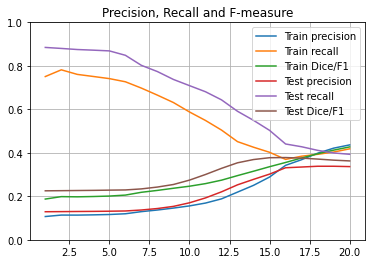

100%|██████████| 20/20 [1:03:07<00:00, 189.38s/it]


pr_c, rec_c, f_meas, pr_nc, rec_nc
[0.3366351728674168, 0.3932635157140531, 0.36275262215400356, 0.911104367801009, 0.8891890003958367]
{'train_loss': 0.5981736779212952, 'train_accuracy': 88.90012926691952, 'train_nochange_accuracy': 94.06877136230469, 'train_change_accuracy': 41.83421325683594, 'test_loss': 0.6761757135391235, 'test_accuracy': 82.71478008882008, 'test_nochange_accuracy': 88.91889953613281, 'test_change_accuracy': 39.326351165771484}
Elapsed time:
3787.815190553665


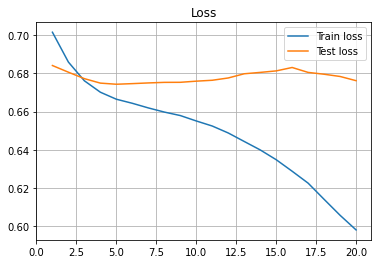

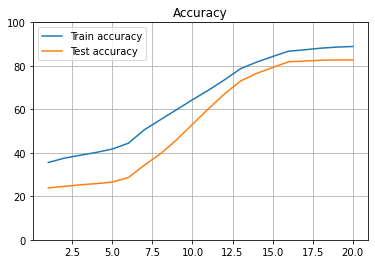

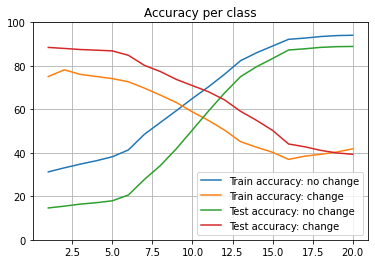

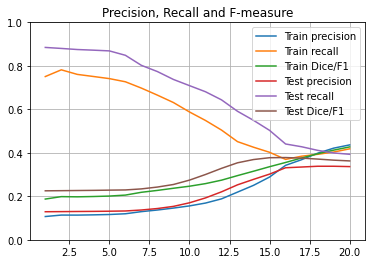

In [19]:
if LOAD_TRAINED:
    #net.load_state_dict(torch.load('net_final.pth.tar'))
    net.load_state_dict(torch.load(PATH_OUTPUTS+'net_final.pth.tar')) # FS
    print('LOAD OK')
else:
    t_start = time.time()
    out_dic = train()
    t_end = time.time()
    print(out_dic)
    print('Elapsed time:')
    print(t_end - t_start)

In [20]:
if not LOAD_TRAINED:
    #torch.save(net.state_dict(), 'net_final.pth.tar')
    torch.save(net.state_dict(), PATH_OUTPUTS+'net_final.pth.tar') # FS
    print('SAVE OK')

SAVE OK


In [21]:


def save_test_results(dset):
    for name in tqdm(dset.names):
        with warnings.catch_warnings():
            I1, I2, cm = dset.get_img(name)
            I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
            I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
            out = net(I1, I2)
            _, predicted = torch.max(out.data, 1)
            I = np.stack((255*cm,255*np.squeeze(predicted.cpu().numpy()),255*cm),2)
            io.imsave(PATH_OUTPUTS+f'{net_name}-{name}.png',I)



t_start = time.time()
# save_test_results(train_dataset)
save_test_results(test_dataset)
t_end = time.time()
print('Elapsed time: {}'.format(t_end - t_start))


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: drive/MyDrive/PRISMA_outputs/FresUNet-Po_01.png is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: drive/MyDrive/PRISMA_outputs/FresUNet-Shanghai.png is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
 50%|█████     | 2/4 [00:00<00:00,  3.07it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: drive/MyDrive/PRISMA_outputs/FresUNet-Indo_01.png is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
 75%|███████▌  | 3/4 [00:00<00:00,  3.31it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: drive/MyDrive/PRISMA_outputs/FresUNet-Aus_fire_01.png is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
1

Elapsed time: 1.1340320110321045


In [22]:
L = 1024

def kappa(tp, tn, fp, fn):
    N = tp + tn + fp + fn
    p0 = (tp + tn) / N
    pe = ((tp+fp)*(tp+fn) + (tn+fp)*(tn+fn)) / (N * N)
    
    return (p0 - pe) / (1 - pe)

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        
        s = cm_full.shape
        
        for ii in range(ceil(s[0]/L)):
            for jj in range(ceil(s[1]/L)):
                xmin = L*ii
                xmax = min(L*(ii+1),s[1])
                ymin = L*jj
                ymax = min(L*(jj+1),s[1])
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
                I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cuda()

                output = net(I1, I2)
                    
                loss = criterion(output, cm.long())
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1
                        
                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()
                
                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count        
    net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, dice, prec_nc, rec_nc]
    
    k = kappa(tp, tn, fp, fn)
    
    return {'net_loss': net_loss, 
            'net_accuracy': net_accuracy, 
            'class_accuracy': class_accuracy, 
            'precision': prec, 
            'recall': rec, 
            'dice': dice, 
            'kappa': k}

results = test(test_dataset)
pprint(results)

100%|██████████| 4/4 [00:32<00:00,  8.07s/it]

{'class_accuracy': [88.65658569335938, 37.834354400634766],
 'dice': 0.3483235642215206,
 'kappa': 0.24668626175740319,
 'net_accuracy': 82.30371475219727,
 'net_loss': 0.6791658401489258,
 'precision': 0.3227173043008584,
 'recall': 0.378343531135084}
